## Hometask 6
## Обучение эмбеддингов (Metric Learning)

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

In [2]:
#%pip uninstall tensorflow -y
#%pip install tensorflow==2.1

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import imageio

import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
train_ds_unbatched, train_info = tfds.load('lfw', as_supervised=True,  with_info=True, split='train[:20%]')

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incompleteUJ7FAP/lfw-train.tfrecord


Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [5]:
train_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [6]:
INP_SIZE = 224

train_x = []
train_y = []
for k, (n,ds) in enumerate(train_ds_unbatched):
    img = ds.numpy().astype(np.float32)/255.
    img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
    train_x.append(img)
    train_y.append(n.numpy())

In [7]:
test_ds_unbatched, test_info = tfds.load('lfw', as_supervised=True, split='train[20%:]', with_info=True)

In [8]:
INP_SIZE = 224

test_x = []
test_y = []
for k, (n,ds) in enumerate(test_ds_unbatched):
    img = ds.numpy().astype(np.float32)/255.
    img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
    test_x.append(img)
    test_y.append(n.numpy())

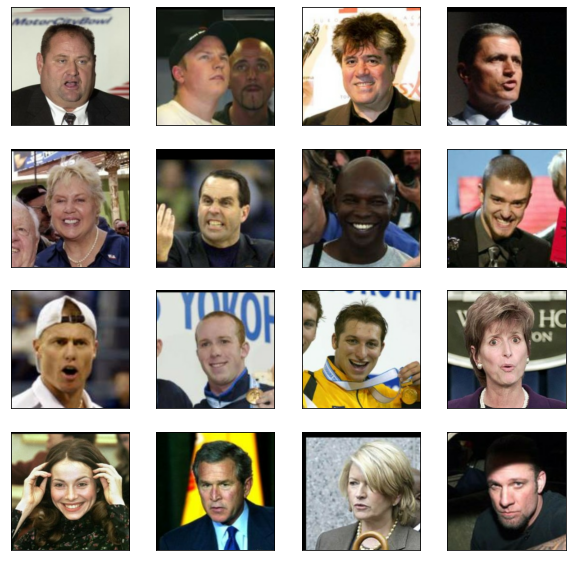

In [9]:
fig = plt.figure(figsize=(10, 10))
for i, image in enumerate(train_x[:16]):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(image)
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание модели CNN

In [10]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [11]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [12]:
BATCH_SIZE = 10
NUM_EPOCHS = 4

train_ds = tf.data.Dataset.from_tensor_slices((train_x[:300], train_y[:300]))
train_ds = train_ds.shuffle(buffer_size=train_x[0].shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

## Подготовка к обучению

In [13]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [14]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 90.16847229003906
CPU times: user 5.41 s, sys: 2.8 s, total: 8.21 s
Wall time: 37.9 s


## Получение эмбеддингов для тестовой выборки

In [15]:
test_xa = np.array(test_x[:10])
test_embs = model(test_xa)

## Функция для визуализации эмбеддингов

In [16]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    k = 0
    for class_idx in targets:
        X_embedded_class = X_embedded[k, :]
        plt.scatter(X_embedded_class[0], X_embedded_class[1])
        k += 1
    plt.legend(labels, loc='best')
    plt.grid(True)

## Визуализация образцов в 2D пространстве с помощью TSNE

In [17]:
test_x_flat = test_xa.reshape(-1, 224*224)
test_x_2D = TSNE(n_components=2).fit_transform(test_x_flat[:10])
labels_for_viz = test_y[:10]

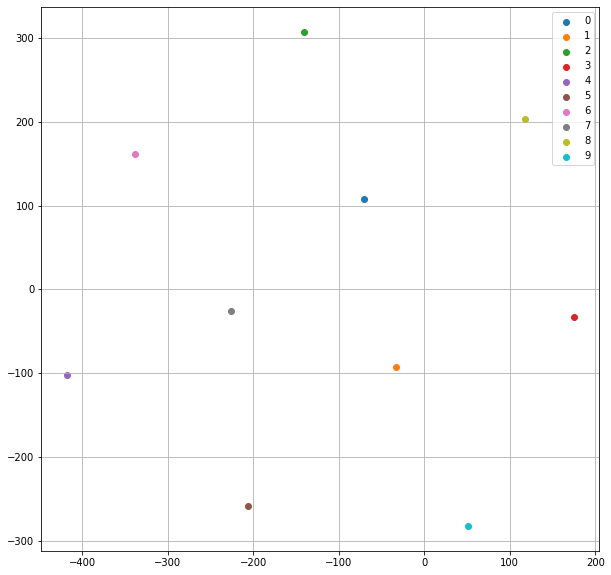

In [18]:
draw_embeddings(test_x_2D, labels_for_viz, list(range(10)))

## Визуализация эмбеддингов в 2D пространстве с помощью TSNE

In [19]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs[:1000])
labels_for_viz = test_y[:1000]

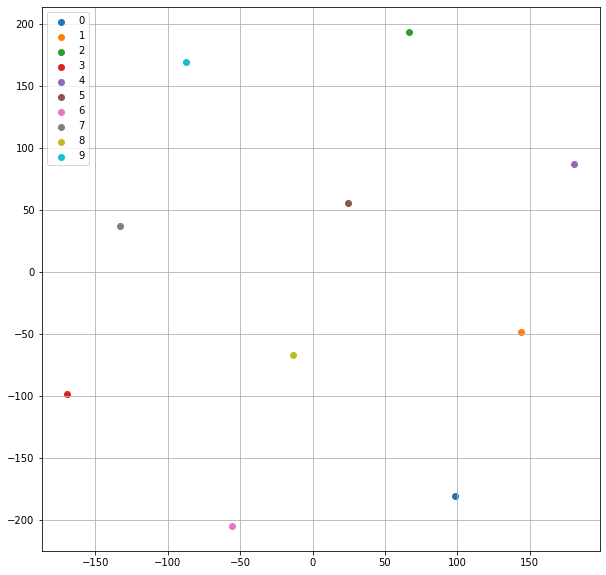

In [20]:
draw_embeddings(test_embs_2D, labels_for_viz[:10], list(range(10)))

## Тестирование на новых данных

In [25]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (224, 224), order=3, mode='reflect', anti_aliasing=True)
    #img = (1. - img).astype(np.float32)
    #img = np.mean(img, axis=2)
    #img = np.reshape(img, (224, 224, -1))
    return img

img_b1 = load_and_prepare_image('DSC00135.jpg')
img_a1 = load_and_prepare_image('DSC00488.jpg')
img_a2 = load_and_prepare_image('IMG_1952.jpg')

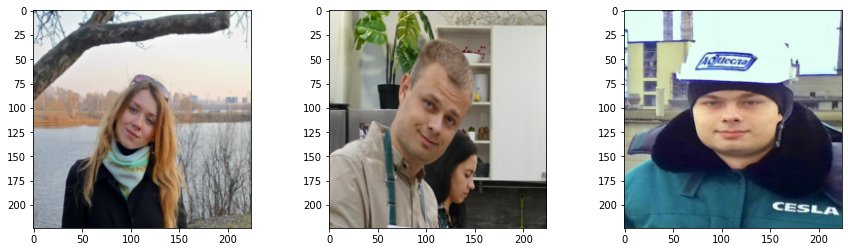

In [26]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1)
plt.show()

## Получение эмбеддингов для новых данных

In [27]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

## Вычисление расстояний между эмбеддингами

In [28]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  31.84256353591938
A2 <-> B1:  45.05472204459401
A1 <-> B1:  21.938472367606153
